# Perceptual decision-making and Psychophysics

如何用MCMC的方法估计weibull心理物理曲线的阈值

## Weibull psychometric function
Weibull函数为
$$
    y = 1 - (1-\gamma)\exp^{-(\frac{k*x}{\alpha})^\beta}
$$
其中
$$
k=-log(\frac{1-g}{1-\gamma})^{\frac{1}{\beta}}
$$


* $\alpha$为该正确率下的threshold
* $\beta$为函数的slope
* $\gamma$为基线chance level的概率值(这里我们固定为0.5)
* * $g$ 为threshold对应的正确率(这里我们固定为0.82)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 先定义weibull函数
def weibullfun(x, alpha, beta, gamma, g):
    k = (-np.log((1-g)/(1-gamma)))**(1/beta)
    y = 1 - (1 - gamma)*np.exp(-(k*x/alpha) ** beta) # hack here to avoid the complex number of 
    return y

Text(0, 0.5, 'Prob of correct')

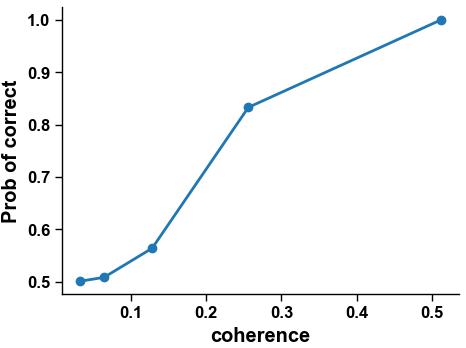

In [6]:
from scipy.stats import bernoulli
coh = np.array([0.032, 0.064, 0.128, 0.256, 0.512]) # coherence level in literature

# 定义参数
g = 0.82
gamma = 0.5 # Baseline chance level
beta = 3. # slop steepness
alpha = 0.25 # coherence threshold corresponding to g

nTrialPerCoh = 1000 # how many trials per coh level

pCoh = weibullfun(coh, alpha, beta, gamma, g)

plt.plot(coh, pCoh, 'o-')
plt.xlabel('coherence')
plt.ylabel('Prob of correct')

In [7]:
data = np.empty((coh.size, nTrialPerCoh))
for iCoh in range(coh.size): # loop coherence level
    # use bernouli process to generate data
    data[iCoh, :] = bernoulli.rvs(pCoh[iCoh], size=nTrialPerCoh)

cohTrial = np.tile(coh[:, np.newaxis], (1, nTrialPerCoh)).flatten() #(5000, ) array
data = data.flatten() # (5000, ) array

* `cohTrial`是一个长度nTrialPerCoh x 5的数组，代表每个trial的coherence level
* `data`是一个长度nTrialPerCoh x 5的数组，代表每个trial被试做对(1)和做错(0)

下面我们写出负对数似然函数
这里我们只假定threshold $\alpha$是需要估计的自由参数

In [8]:
eps = np.finfo(float).eps
def negloglikeli(alpha, coh, data):
    gamma = 0.5
    g = 0.82
    beta = 3.

    prob = np.empty(coh.size)
    for i in range(coh.size):
        p = weibullfun(coh[i], alpha, beta, gamma, g)
        prob[i] = p*data[i]+(1-p)*(1-data[i])
    
    prob = prob*0.999+eps # 避免prob里面有0的情况, log(0)=-infinity
    return -np.log(prob).sum()

下面来负责写MCMC的部分了

In [17]:
from numpy import log
from scipy.stats import norm

nSample = 1000
nBurnin = 1000
nTotalSample = nSample + nBurnin

stepsize = 1

samples = []

oldsample = 0
trans_oldsample = 1/(1+np.exp(-oldsample))
for i in range(nTotalSample):
    newsample = norm.rvs(loc=oldsample, scale=stepsize)
    # 我们的参数(0,1),但是我们转化到纯实数范围内采集
    trans_newsample = 1/(1+np.exp(-newsample))

    # calculate difference
    delta = negloglikeli(trans_oldsample, cohTrial, data)-negloglikeli(trans_newsample, cohTrial, data)

    if delta > 0: # accept new sample for sure
        samples.append(trans_newsample.copy())
        trans_oldsample = trans_newsample
        oldsample = newsample
    else:
        tt = np.random.rand()
        if log(tt)< delta: # accet new sample
            samples.append(trans_newsample.copy())
            trans_oldsample = trans_newsample
            oldsample = newsample
        else:
            samples.append(trans_oldsample.copy())
        

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.25976519, -0.15976519, -0.05976519,  0.04023481,  0.14023481,
         0.24023481,  0.34023481,  0.44023481,  0.54023481,  0.64023481,
         0.74023481]),
 <BarContainer object of 10 artists>)

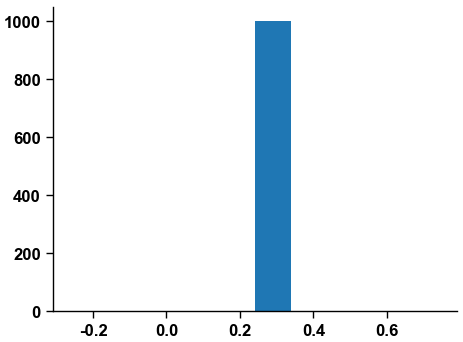

In [18]:
plt.hist(samples[1000:])